## Import librarires

In [66]:
## Import libraries for machine learning and data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
## import dataset
raw_feature_df_scaled = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_v100.csv')
## Display the first few rows of the dataset
raw_feature_df_scaled.head(3)

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_24.0,wake_day_part_25.0,wake_day_part_26.0,wake_day_part_27.0,wake_day_part_28.0,wake_day_part_29.0,wake_day_part_30.0,wake_day_part_31.0,wake_day_part_32.0,wake_day_part_33.0
0,arrivejanitoruniformly@timestudy_com,1,1,0.0,0.0,0,0.000002,0.0,0.0,0.187031,...,0,0,0,0,0,0,0,0,0,0
1,arrivejanitoruniformly@timestudy_com,1,1,0.0,0.0,0,0.000002,0.0,0.0,0.180555,...,0,0,0,0,0,0,0,0,0,0
2,arrivejanitoruniformly@timestudy_com,1,1,0.0,0.0,0,0.000002,0.0,0.0,0.176050,...,0,0,0,0,0,0,0,0,0,0


## Split training and test data
10 participants in training and 90 in testing

In [26]:
def split_train_test_by_participant(df, id_col='participant_id', n_train=10, n_test=90, random_state=42):
    """
    Splits the DataFrame into training and testing sets based on participant_id.
    n_train: number of unique participants in training set
    n_test: number of unique participants in test set
    Returns: train_df, test_df
    """
    np.random.seed(random_state)
    unique_ids = df[id_col].unique()
    shuffled_ids = np.random.permutation(unique_ids)
    train_ids = shuffled_ids[:n_train]
    test_ids = shuffled_ids[n_train:n_train+n_test]
    train_df = df[df[id_col].isin(train_ids)].reset_index(drop=True)
    test_df = df[df[id_col].isin(test_ids)].reset_index(drop=True)
    return train_df, test_df

# Example usage:
train_df, test_df = split_train_test_by_participant(raw_feature_df_scaled)
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (91808, 62)
Test set shape: (995545, 62)


In [27]:
# Print participant_ids in train and test sets
print("Train participant_ids:", sorted(train_df['participant_id'].unique()))
print("Test participant_ids:", sorted(test_df['participant_id'].unique()))

Train participant_ids: ['arrivejanitoruniformly@timestudy_com', 'chewingslouchingfailing@timestudy_com', 'doorpostthesisjubilance@timestudy_com', 'housewagontrivial@timestudy_com', 'lardcapablemud@timestudy_com', 'larkshiningaffected@timestudy_com', 'nicknameoverpaycolt@timestudy_com', 'retrialgraftedsturdy@timestudy_com', 'sublevelcurlyhanky@timestudy_com', 'synapseevaluatechevron@timestudy_com']
Test participant_ids: ['atlanticchefhatchet@timestudy_com', 'badlandwiltmuseum@timestudy_com', 'bannisterhardwiredladle@timestudy_com', 'bartenderradiatorapplied@timestudy_com', 'beavertomatoupscale@timestudy_com', 'bondingcoasterdirtiness@timestudy_com', 'brinkaminounframed@timestudy_com', 'catsupexploitmocker@timestudy_com', 'certifiedembargobartender@timestudy_com', 'cohesiveprotractfavored@timestudy_com', 'collisionmolarbreeze@timestudy_com', 'congestedculpritsaved@timestudy_com', 'congresscyclistdefender@timestudy_com', 'copybrickcreative@timestudy_com', 'coynessculminatebarista@timestud

In [28]:
# Create a table of participant_id, set (train/test), and number of observations
train_counts = train_df['participant_id'].value_counts().rename('n_observations').reset_index().rename(columns={'index': 'participant_id'})
train_counts['set'] = 'train'
test_counts = test_df['participant_id'].value_counts().rename('n_observations').reset_index().rename(columns={'index': 'participant_id'})
test_counts['set'] = 'test'
participant_table = pd.concat([train_counts, test_counts], ignore_index=True)
participant_table = participant_table[['participant_id', 'set', 'n_observations']]
participant_table = participant_table.sort_values(['set', 'participant_id']).reset_index(drop=True)
print(participant_table)

                            participant_id    set  n_observations
0        atlanticchefhatchet@timestudy_com   test           13238
1          badlandwiltmuseum@timestudy_com   test           12257
2    bannisterhardwiredladle@timestudy_com   test           12757
3   bartenderradiatorapplied@timestudy_com   test            4692
4        beavertomatoupscale@timestudy_com   test           13099
..                                     ...    ...             ...
95       larkshiningaffected@timestudy_com  train           13047
96       nicknameoverpaycolt@timestudy_com  train            6739
97      retrialgraftedsturdy@timestudy_com  train            3707
98        sublevelcurlyhanky@timestudy_com  train            8089
99    synapseevaluatechevron@timestudy_com  train            8584

[100 rows x 3 columns]


## Apply median imputation to training data first

In [29]:
def impute_training_with_median(train_df, id_col='participant_id', outcome_col='outcome'):
    """
    Impute missing values in all feature columns of train_df using the median within each participant_id group.
    If a group has all missing values for a column, fallback to the global median for that column.
    Returns a new DataFrame with imputed values.
    """
    import pandas as pd
    skip_cols = [id_col, outcome_col]
    cols_to_impute = [col for col in train_df.columns if col not in skip_cols]
    df_result = train_df.copy()
    global_medians = train_df[cols_to_impute].median()
    def impute_group(group):
        group_medians = group[cols_to_impute].median()
        fill_values = group_medians.fillna(global_medians)
        return group[cols_to_impute].fillna(fill_values)
    df_result[cols_to_impute] = train_df.groupby(id_col, group_keys=False).apply(impute_group)
    return df_result

# Example usage:
train_df = impute_training_with_median(train_df)


/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_30657/2809463938.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_result[cols_to_impute] = train_df.groupby(id_col, group_keys=False).apply(impute_group)


In [30]:
# Print the percentage of missing values for each column in train_df
missing_pct_train = train_df.isnull().mean() * 100
print("% Missing values per column in train_df:")
print(missing_pct_train.sort_values(ascending=False))

% Missing values per column in train_df:
participant_id               0.0
wake_day_part_17.0           0.0
wake_day_part_3.0            0.0
wake_day_part_4.0            0.0
wake_day_part_5.0            0.0
                            ... 
location_category_Home       0.0
location_category_Other      0.0
location_category_School     0.0
location_category_Transit    0.0
wake_day_part_33.0           0.0
Length: 62, dtype: float64


## Apply SMOTE to training data
To handle the class imbalance

In [31]:
# Apply SMOTE to the training data to address class imbalance, including participant_id
feature_cols = [col for col in train_df.columns if col not in ['outcome', 'participant_id']]
X_train = train_df[feature_cols]
y_train = train_df['outcome']
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Convert back to DataFrame with feature names to avoid warning
X_train_resampled = pd.DataFrame(X_train_resampled, columns=feature_cols)
print('Original training set class distribution:')
print(y_train.value_counts())
print('Resampled training set class distribution:')
print(pd.Series(y_train_resampled).value_counts())

Original training set class distribution:
outcome
1    75442
0    16366
Name: count, dtype: int64
Resampled training set class distribution:
outcome
1    75442
0    75442
Name: count, dtype: int64


# Using Random Forest

In [32]:
def train_random_forest_classifier(X, y, random_state=42):
    """
    Trains a RandomForestClassifier on the provided features and labels.
    Uses class_weight='balanced' to handle class imbalance.
    Returns the trained model.
    """
    clf = RandomForestClassifier(
        class_weight='balanced',
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=10,
        max_features='sqrt',
        n_estimators=100,
        random_state=random_state
    )
    clf.fit(X, y)
    return clf

# Example usage:
rf_model = train_random_forest_classifier(X_train_resampled, y_train_resampled)

## Test the model

In [ ]:
def evaluate_classifier_on_test(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Evaluates the classifier on test_df and returns accuracy, precision, recall, F1, and AUC.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0, pos_label=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}' if auc is not None else 'AUC: Not available')
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

# Example usage:
results = evaluate_classifier_on_test(rf_model, test_df)

Accuracy: 0.7630
Precision: 0.8880
Recall: 0.8016
F1 Score: 0.8426
AUC: 0.7794


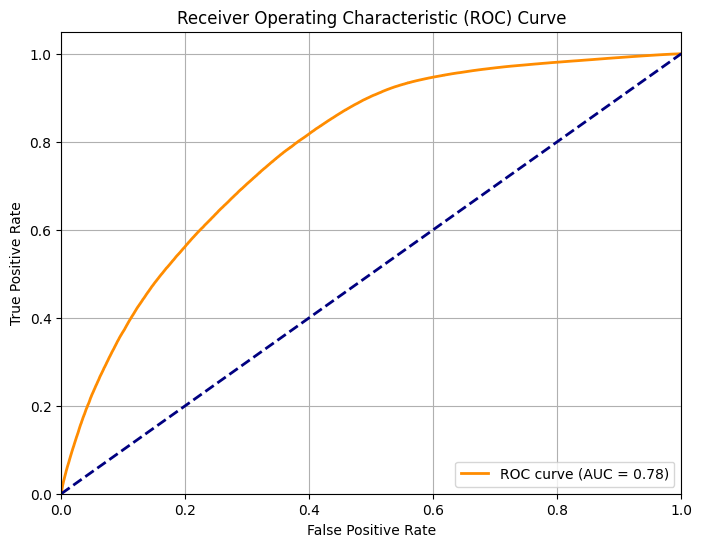

In [34]:
def plot_roc_curve(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the ROC curve for the given model and test DataFrame.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        raise ValueError('Model does not support predict_proba, cannot plot ROC curve.')
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Example usage:
plot_roc_curve(rf_model, test_df)

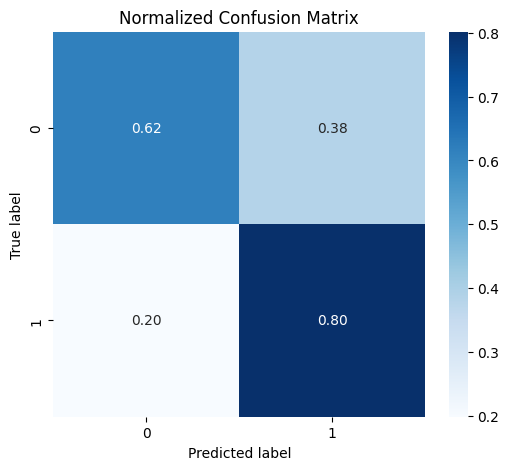

In [35]:
def plot_confusion_matrix(model, test_df, outcome_col='outcome', id_col='participant_id', cmap='Blues'):
    """
    Plots the normalized confusion matrix for the given model and test DataFrame.
    """
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# Example usage:
plot_confusion_matrix(rf_model, test_df)

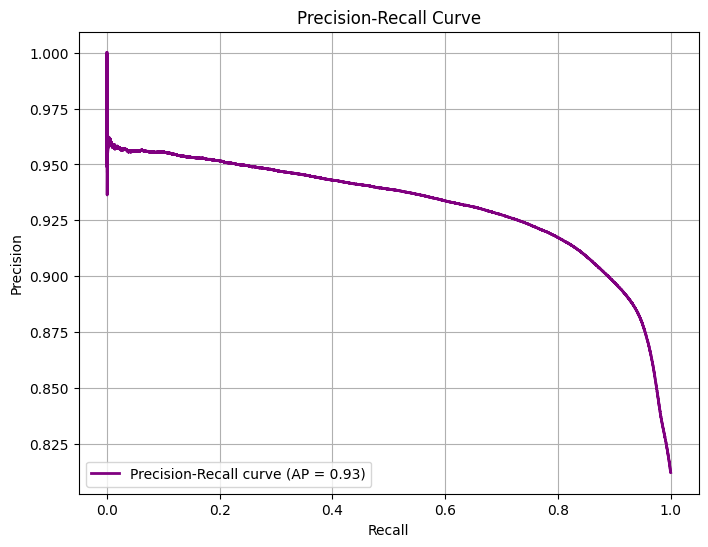

In [13]:
def plot_precision_recall_curve(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the precision-recall curve for the given model and test DataFrame.
    """
    from sklearn.metrics import precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        raise ValueError('Model does not support predict_proba, cannot plot precision-recall curve.')
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Example usage:
plot_precision_recall_curve(rf_model, test_df)

In [36]:
def plot_precision_recall_f1_vs_threshold(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots precision, recall, and F1 score as a function of the decision threshold for the given model and test DataFrame.
    """
    from sklearn.metrics import precision_recall_curve, f1_score
    import matplotlib.pyplot as plt
    import numpy as np
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        raise ValueError('Model does not support predict_proba, cannot plot precision/recall/f1 vs. threshold.')
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    # F1 for each threshold (skip last threshold, as precision_recall_curve returns an extra value)
    f1 = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1.append(f1_score(y_test, y_pred, zero_division=0))
    f1 = np.array(f1)
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
    plt.plot(thresholds, recall[:-1], label='Recall', color='green')
    plt.plot(thresholds, f1, label='F1 Score', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_precision_recall_f1_vs_threshold(rf_model, test_df)

KeyboardInterrupt: 

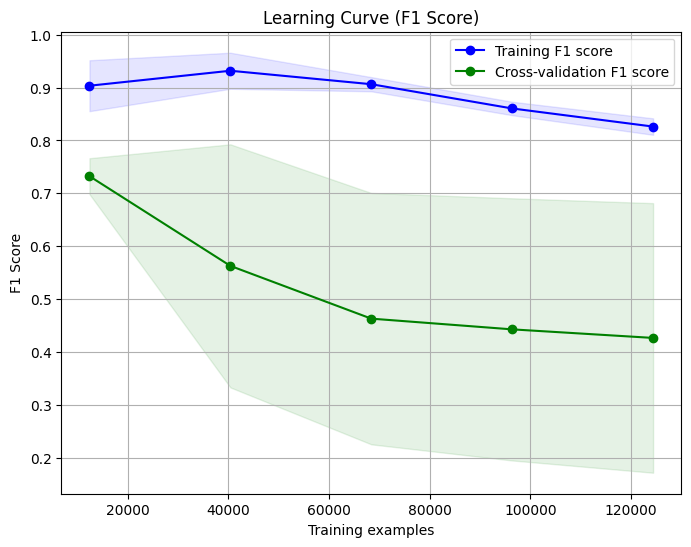

In [19]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=None, random_state=42):
    """
    Plots the learning curve for the given estimator using F1 score as the metric.
    """
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='f1', train_sizes=train_sizes, random_state=random_state)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training F1 score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation F1 score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='green')
    plt.xlabel('Training examples')
    plt.ylabel('F1 Score')
    plt.title('Learning Curve (F1 Score)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example usage:
plot_learning_curve(rf_model, X_train_resampled, y_train_resampled)

### Grid search for hyper parameter tuning

In [20]:
def grid_search_random_forest(X, y, cv=5, random_state=42):
    """
    Performs grid search to find the best hyperparameters for RandomForestClassifier.
    Returns the best estimator and the grid search results as a DataFrame.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    import pandas as pd
    param_grid = {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'n_estimators': [100, 200]
    }
    clf = RandomForestClassifier(class_weight='balanced', max_features='sqrt', random_state=random_state)
    grid_search = GridSearchCV(clf, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best F1 score: {grid_search.best_score_:.4f}')
    results_df = pd.DataFrame(grid_search.cv_results_)
    return grid_search.best_estimator_, results_df

# Example usage:
best_rf_model, grid_results = grid_search_random_forest(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.7s
[CV] END max_depth=5, min_samples_leaf

/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  32.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  32.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  30.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  30.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  30.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  30.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estim

In [21]:
def train_best_model(best_estimator, X, y):
    """
    Retrains the best estimator from grid search on the full training data.
    Returns the trained model.
    """
    best_estimator.fit(X, y)
    return best_estimator

# Example usage:
final_rf_model = train_best_model(best_rf_model, X_train_resampled, y_train_resampled)

In [22]:
# Test the final_rf_model on the test data
final_results = evaluate_classifier_on_test(final_rf_model, test_df)

Accuracy: 0.6144
Precision: 0.9003
Recall: 0.5890
F1 Score: 0.7121
AUC: 0.7465


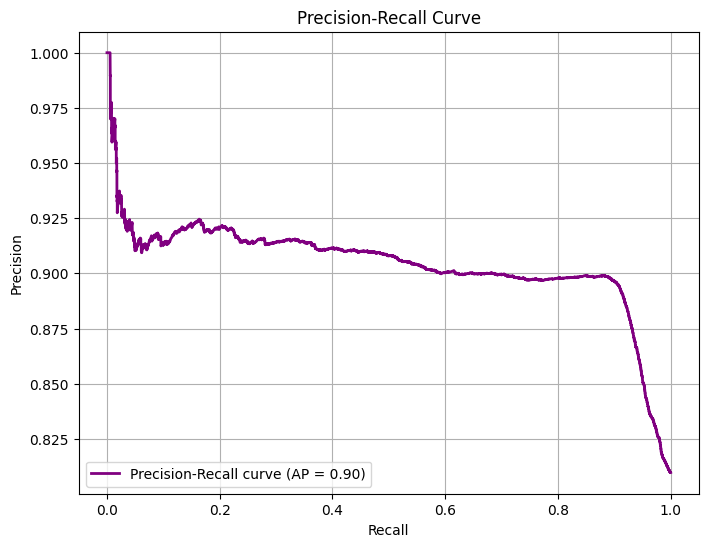

In [23]:
# Plot the precision-recall curve for the final_rf_model on the test data
plot_precision_recall_curve(final_rf_model, test_df)

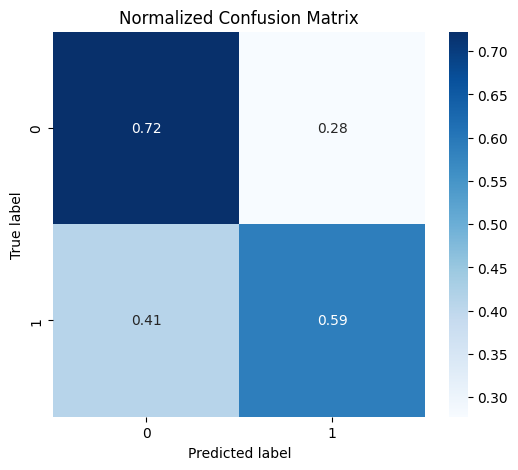

In [24]:
# Plot the normalized confusion matrix for the final_rf_model on the test data
plot_confusion_matrix(final_rf_model, test_df)

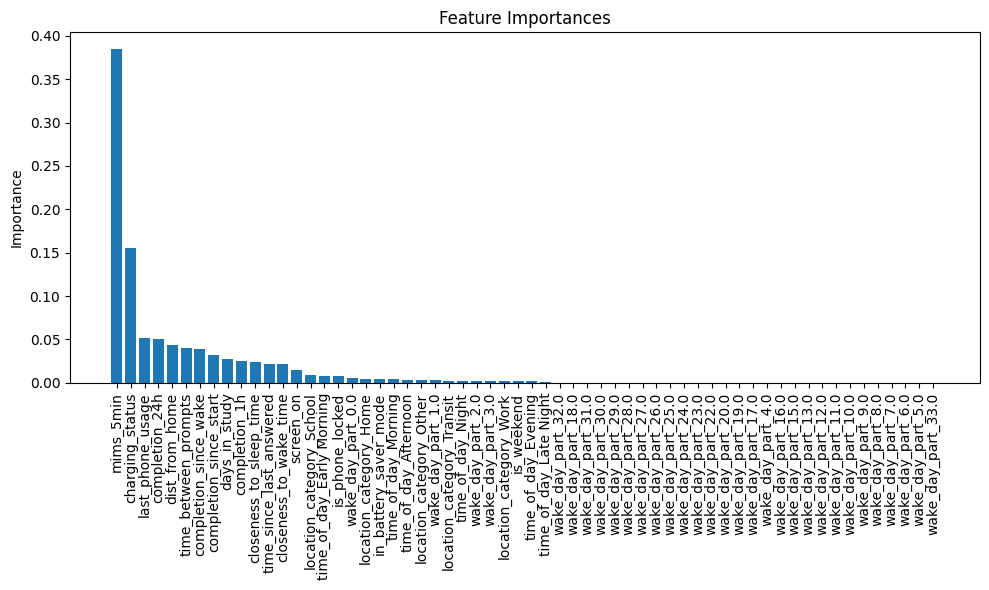

In [37]:
def plot_feature_importance(model, feature_names, top_n=None):
    """
    Plots the feature importances for a fitted RandomForest model.
    If top_n is specified, only the top_n features are shown.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    if top_n is not None:
        indices = indices[:top_n]
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_feature_importance(rf_model, X_train_resampled.columns)

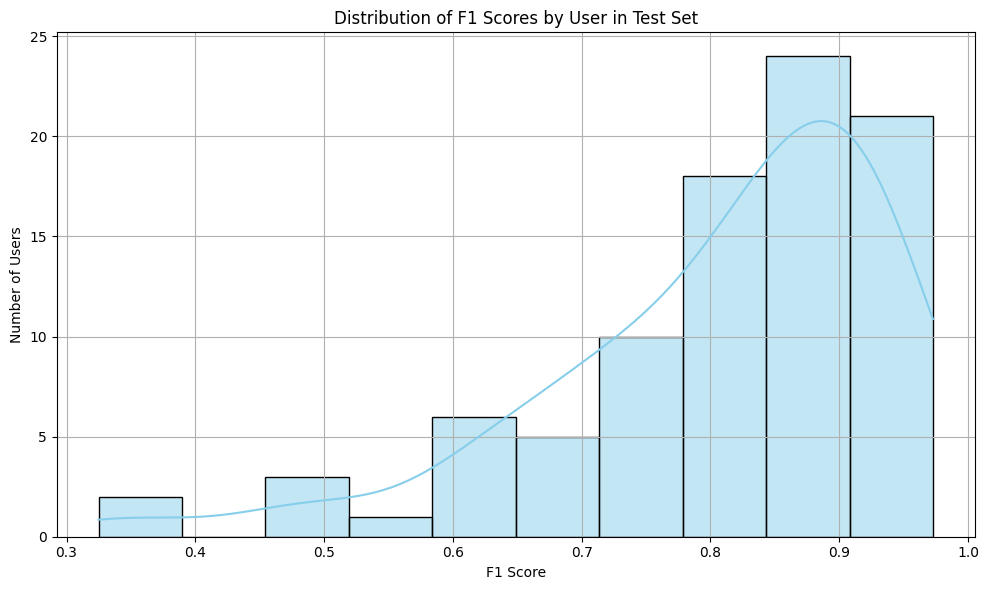

In [38]:
def plot_f1_distribution_by_user(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the distribution of F1 scores for each user (participant_id) in the test set and returns the matplotlib figure object.
    """
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    user_ids = test_df[id_col].unique()
    f1_scores = []
    for user in user_ids:
        user_df = test_df[test_df[id_col] == user]
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X_user = user_df[feature_cols]
        y_user = user_df[outcome_col]
        if len(y_user.unique()) < 2:
            # F1 score is undefined if only one class is present; skip or set to NaN
            f1 = float('nan')
        else:
            y_pred = model.predict(X_user)
            f1 = f1_score(y_user, y_pred, zero_division=0)
        f1_scores.append({'participant_id': user, 'f1_score': f1})
    f1_df = pd.DataFrame(f1_scores)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(f1_df['f1_score'].dropna(), bins=10, kde=True, color='skyblue', ax=ax)
    ax.set_xlabel('F1 Score')
    ax.set_ylabel('Number of Users')
    ax.set_title('Distribution of F1 Scores by User in Test Set')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    return fig

# Example usage:
user_f1_fig = plot_f1_distribution_by_user(rf_model, test_df)

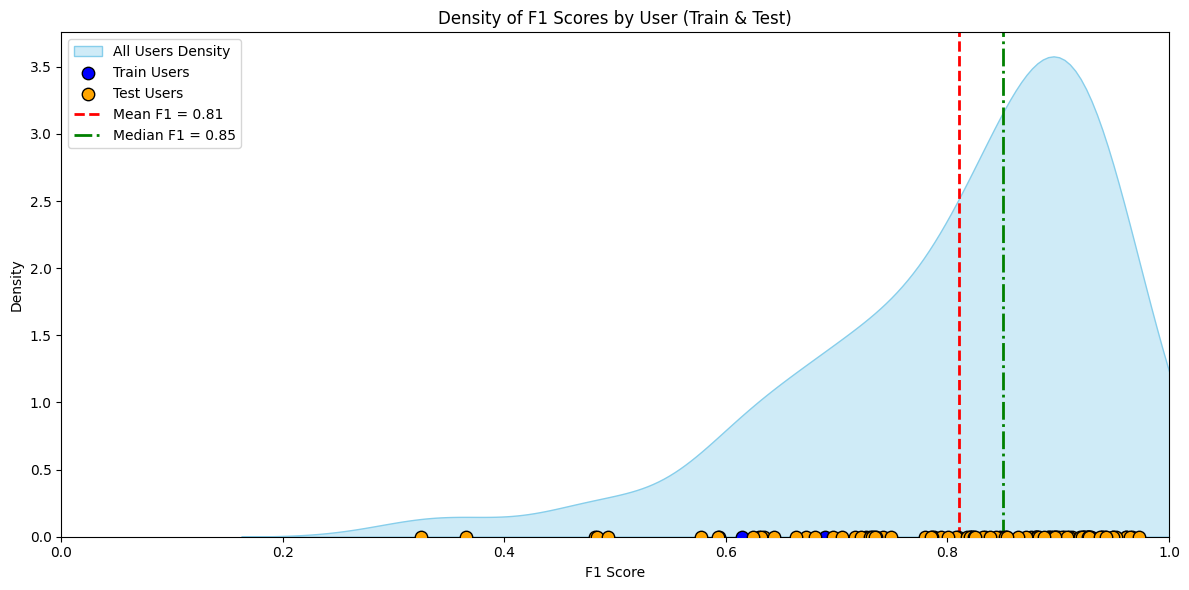

In [39]:
def plot_f1_by_user_train_test(model, train_df, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the density of F1 scores for all users in train and test sets, overlays all users as dots, highlights test users as orange dots, and adds vertical lines for mean and median F1 scores.
    Returns the matplotlib figure object.
    """
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    # Helper to compute F1 per user
    def compute_f1_per_user(df, label):
        user_ids = df[id_col].unique()
        f1_scores = []
        for user in user_ids:
            user_df = df[df[id_col] == user]
            feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
            X_user = user_df[feature_cols]
            y_user = user_df[outcome_col]
            if len(y_user.unique()) < 2:
                f1 = float('nan')
            else:
                y_pred = model.predict(X_user)
                f1 = f1_score(y_user, y_pred, zero_division=0)
            f1_scores.append({'participant_id': user, 'f1_score': f1, 'set': label})
        return pd.DataFrame(f1_scores)
    train_f1 = compute_f1_per_user(train_df, 'train')
    test_f1 = compute_f1_per_user(test_df, 'test')
    all_f1 = pd.concat([train_f1, test_f1], ignore_index=True)
    f1_scores_clean = all_f1['f1_score'].dropna()
    mean_f1 = f1_scores_clean.mean()
    median_f1 = f1_scores_clean.median()
    fig, ax = plt.subplots(figsize=(12, 6))
    # Density plot for all users (train + test)
    sns.kdeplot(f1_scores_clean, fill=True, color='skyblue', alpha=0.4, ax=ax, label='All Users Density')
    # Overlay all users as dots (train: blue, test: orange)
    train_points = train_f1.dropna(subset=['f1_score'])
    test_points = test_f1.dropna(subset=['f1_score'])
    ax.scatter(train_points['f1_score'], [0]*len(train_points), color='blue', s=80, label='Train Users', zorder=3, edgecolor='k')
    ax.scatter(test_points['f1_score'], [0]*len(test_points), color='orange', s=80, label='Test Users', zorder=4, edgecolor='k')
    # Add vertical lines for mean and median
    ax.axvline(mean_f1, color='red', linestyle='--', linewidth=2, label=f'Mean F1 = {mean_f1:.2f}')
    ax.axvline(median_f1, color='green', linestyle='-.', linewidth=2, label=f'Median F1 = {median_f1:.2f}')
    ax.set_xlabel('F1 Score')
    ax.set_ylabel('Density')
    ax.set_title('Density of F1 Scores by User (Train & Test)')
    ax.set_xlim(0, 1)
    ax.legend()
    plt.tight_layout()
    plt.show()
    return fig

# Example usage:
f1_by_user_fig = plot_f1_by_user_train_test(rf_model, train_df, test_df)

## Rework cross validation from scratch

In [121]:
def cross_validate_rf_with_group_smote(raw_feature_df, group_col='participant_id', label_col='outcome', cv=5, random_state=42):
    """
    Performs 5-fold cross-validation using GroupKFold with participant_id as the group. Applies SMOTE to each training fold (grouped by participant_id), trains a balanced RandomForest, and returns arrays of accuracy, precision, recall, F1, mean F1, and lists of y_true/y_pred for each fold for confusion matrix plotting.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GroupKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from imblearn.over_sampling import SMOTE
    import numpy as np
    import pandas as pd

    feature_cols = [col for col in raw_feature_df.columns if col not in [label_col, group_col]]
    X = raw_feature_df[feature_cols]
    y = raw_feature_df[label_col]
    groups = raw_feature_df[group_col]

    gkf = GroupKFold(n_splits=cv)
    accuracy_arr, precision_arr, recall_arr, f1_arr = [], [], [], []
    y_true_folds, y_pred_folds = [], []

    for _, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        train_groups = groups.iloc[train_idx]

        X_train_smote_list, y_train_smote_list, pid_list = [], [], []
        for pid in train_groups.unique():
            mask = train_groups == pid
            X_pid = X_train[mask]
            y_pid = y_train[mask]
            if len(np.unique(y_pid)) > 1:
                smote = SMOTE(random_state=random_state)
                X_pid_res, y_pid_res = smote.fit_resample(X_pid, y_pid)
                X_train_smote_list.append(X_pid_res)
                y_train_smote_list.append(y_pid_res)
                pid_list.extend([pid]*len(y_pid_res))
            else:
                X_train_smote_list.append(X_pid.values)
                y_train_smote_list.append(y_pid.values)
                pid_list.extend([pid]*len(y_pid))
        X_train_resampled = np.vstack(X_train_smote_list)
        y_train_resampled = np.concatenate(y_train_smote_list)
        X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=feature_cols)
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=random_state)
        clf.fit(X_train_resampled_df, y_train_resampled)
        y_pred = clf.predict(X_test)
        accuracy_arr.append(accuracy_score(y_test, y_pred))
        precision_arr.append(precision_score(y_test, y_pred, zero_division=0))
        recall_arr.append(recall_score(y_test, y_pred, zero_division=0))
        f1_arr.append(f1_score(y_test, y_pred, zero_division=0))
        y_true_folds.append(y_test.values)
        y_pred_folds.append(y_pred)
    mean_f1 = np.mean(f1_arr)
    print("Accuracy array:", accuracy_arr)
    print("Precision array:", precision_arr)
    print("Recall array:", recall_arr)
    print("F1 array:", f1_arr)
    print(f"Mean F1 score across {cv} folds: {mean_f1:.4f}")
    return accuracy_arr, precision_arr, recall_arr, f1_arr, mean_f1, y_true_folds, y_pred_folds

# Example usage:
accuracy_arr, precision_arr, recall_arr, f1_arr, mean_f1, y_true_folds, y_pred_folds = cross_validate_rf_with_group_smote(raw_feature_df_scaled)

KeyboardInterrupt: 

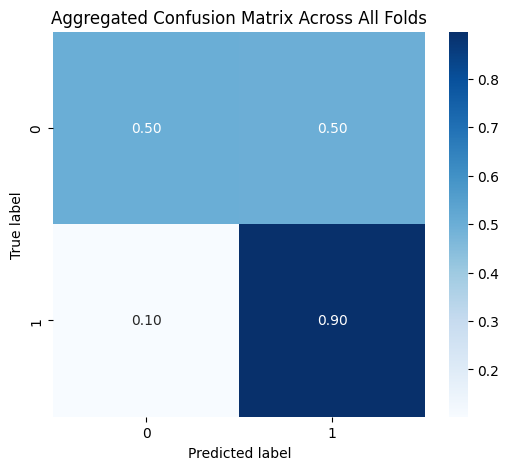

Aggregate Precision: 0.9224
Aggregate Recall: 0.8976
Aggregate F1 Score: 0.9098


In [70]:
def plot_aggregated_confusion_matrix(y_true_folds, y_pred_folds, labels=None, normalize='true', cmap='Blues'):
    """
    Plots the confusion matrix aggregated over all folds (concatenated y_true and y_pred) using the outputs from cross_validate_rf_with_group_smote.
    Also prints aggregate precision, recall, and f1 score.
    Args:
        y_true_folds: list of arrays of true labels for each fold
        y_pred_folds: list of arrays of predicted labels for each fold
        labels: list of class labels (optional)
        normalize: 'true', 'pred', or None for normalization (default: 'true')
        cmap: matplotlib colormap (default: 'Blues')
    """
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Concatenate all y_true and y_pred across folds
    y_true_all = np.concatenate(y_true_folds)
    y_pred_all = np.concatenate(y_pred_folds)
    # Use labels from all data if not provided
    if labels is None:
        labels = np.unique(y_true_all)
    cm = confusion_matrix(y_true_all, y_pred_all, labels=labels, normalize=normalize)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Aggregated Confusion Matrix Across All Folds')
    plt.show()

    # Print aggregate precision, recall, f1
    precision = precision_score(y_true_all, y_pred_all, average='binary', zero_division=0)
    recall = recall_score(y_true_all, y_pred_all, average='binary', zero_division=0)
    f1 = f1_score(y_true_all, y_pred_all, average='binary', zero_division=0)
    print(f'Aggregate Precision: {precision:.4f}')
    print(f'Aggregate Recall: {recall:.4f}')
    print(f'Aggregate F1 Score: {f1:.4f}')

# Example usage:
plot_aggregated_confusion_matrix(y_true_folds, y_pred_folds)

In [40]:
def reverse_groupkfold_cv_rf_smote(raw_feature_df_scaled, group_col='participant_id', label_col='outcome', n_splits=5, random_state=42):
    """
    Custom GroupKFold cross-validation:
    - Splits data into n_splits at participant_id level
    - For each fold, trains on ONE split and tests on the remaining splits (reverse of typical GroupKFold)
    - Imputes missing data in training split using median grouped by participant_id
    - Applies SMOTE to the training split
    - Uses RandomForestClassifier with class_weight='balanced'
    - Returns mean accuracy, precision, recall, and f1 across folds
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from imblearn.over_sampling import SMOTE
    import numpy as np
    import pandas as pd

    def impute_missing_with_median(df, group_col, skip_cols):
        cols_to_impute = [col for col in df.columns if col not in skip_cols]
        df_result = df.copy()
        global_medians = df[cols_to_impute].median()
        def impute_group(group):
            group_medians = group[cols_to_impute].median()
            fill_values = group_medians.fillna(global_medians)
            return group[cols_to_impute].fillna(fill_values)
        df_result[cols_to_impute] = df.groupby(group_col, group_keys=False).apply(impute_group)
        return df_result

    # Get unique participant_ids and shuffle
    unique_ids = raw_feature_df_scaled[group_col].unique()
    np.random.seed(random_state)
    shuffled_ids = np.random.permutation(unique_ids)
    splits = np.array_split(shuffled_ids, n_splits)

    accuracy_arr, precision_arr, recall_arr, f1_arr = [], [], [], []

    for i in range(n_splits):
        train_ids = splits[i]
        test_ids = np.concatenate([splits[j] for j in range(n_splits) if j != i])
        train_df = raw_feature_df_scaled[raw_feature_df_scaled[group_col].isin(train_ids)]
        test_df = raw_feature_df_scaled[raw_feature_df_scaled[group_col].isin(test_ids)]
        feature_cols = [col for col in raw_feature_df_scaled.columns if col not in [label_col, group_col]]

        # Impute missing data in training split using median grouped by participant_id
        train_df_imputed = impute_missing_with_median(train_df, group_col, [group_col, label_col])

        # SMOTE on training split
        X_train = train_df_imputed[feature_cols]
        y_train = train_df_imputed[label_col]
        if len(np.unique(y_train)) > 1:
            smote = SMOTE(random_state=random_state)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        else:
            X_train_resampled, y_train_resampled = X_train.values, y_train.values
        X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=feature_cols)
        # Train RF
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=random_state)
        clf.fit(X_train_resampled_df, y_train_resampled)
        # Test
        X_test = test_df[feature_cols]
        y_test = test_df[label_col]
        y_pred = clf.predict(X_test)
        accuracy_arr.append(accuracy_score(y_test, y_pred))
        precision_arr.append(precision_score(y_test, y_pred, zero_division=0))
        recall_arr.append(recall_score(y_test, y_pred, zero_division=0))
        f1_arr.append(f1_score(y_test, y_pred, zero_division=0))
    mean_accuracy = np.mean(accuracy_arr)
    mean_precision = np.mean(precision_arr)
    mean_recall = np.mean(recall_arr)
    mean_f1 = np.mean(f1_arr)
    print('Accuracy array:', accuracy_arr)
    print('Precision array:', precision_arr)
    print('Recall array:', recall_arr)
    print('F1 array:', f1_arr)
    print(f'Mean Accuracy: {mean_accuracy:.4f}')
    print(f'Mean Precision: {mean_precision:.4f}')
    print(f'Mean Recall: {mean_recall:.4f}')
    print(f'Mean F1: {mean_f1:.4f}')
    return mean_accuracy, mean_precision, mean_recall, mean_f1

# Example usage:
mean_accuracy, mean_precision, mean_recall, mean_f1 = reverse_groupkfold_cv_rf_smote(raw_feature_df_scaled)

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_30657/1098720647.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_result[cols_to_impute] = df.groupby(group_col, group_keys=False).apply(impute_group)
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_30657/1098720647.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_result[cols_to_impute] = df.groupby(group_col, group_keys=False).apply(

Accuracy array: [0.7690217482313724, 0.7340533848592486, 0.7413669488294771, 0.7903053117322497, 0.7967962933674079]
Precision array: [0.8905259822560203, 0.9095651206163379, 0.9018681423860364, 0.888128060299499, 0.9027103240611455]
Recall array: [0.8054733843244248, 0.7384485346624113, 0.7579950417212101, 0.8379484201751852, 0.8385887441859153]
F1 array: [0.8458670337864969, 0.8151231372965373, 0.8236962982977574, 0.8623088414211572, 0.8694689279081275]
Mean Accuracy: 0.7663
Mean Precision: 0.8986
Mean Recall: 0.7957
Mean F1: 0.8433


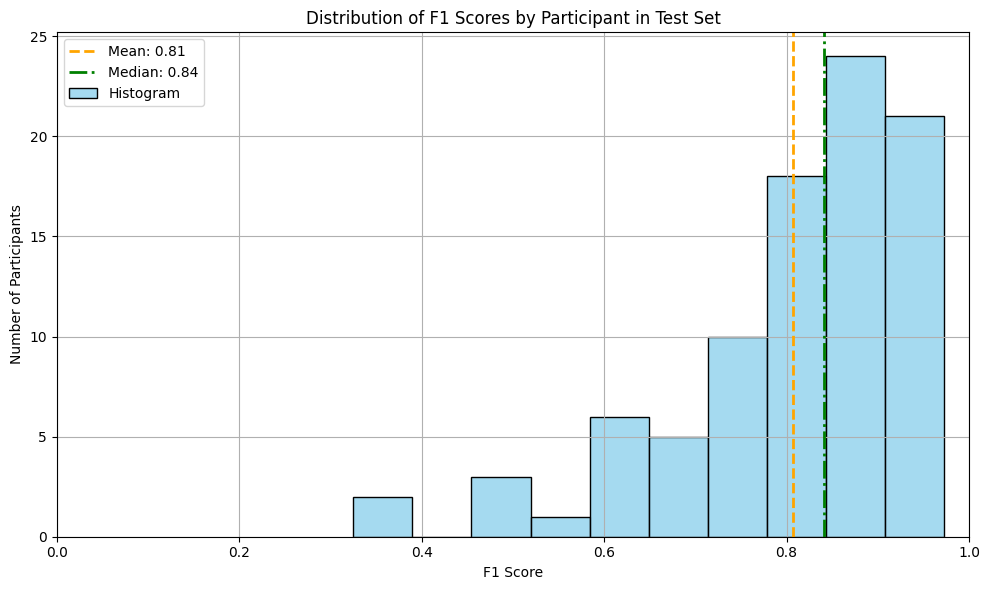

In [41]:
def plot_f1_distribution_by_participant(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the distribution of F1 scores for each participant in test_df using the trained model.
    Shows mean and median F1 score lines.
    """
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    participant_ids = test_df[id_col].unique()
    f1_scores = []
    for pid in participant_ids:
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        y_true = user_df[outcome_col]
        if len(y_true.unique()) < 2:
            f1 = float('nan')  # F1 undefined if only one class
        else:
            X = user_df[feature_cols]
            y_pred = model.predict(X)
            f1 = f1_score(y_true, y_pred, zero_division=0)
        f1_scores.append({'participant_id': pid, 'f1_score': f1})
    f1_df = pd.DataFrame(f1_scores)

    mean_f1 = f1_df['f1_score'].mean()
    median_f1 = f1_df['f1_score'].median()

    plt.figure(figsize=(10, 6))
    sns.histplot(f1_df['f1_score'].dropna(), bins=10, kde=False, color='skyblue', label='Histogram')
    plt.axvline(mean_f1, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_f1:.2f}')
    plt.axvline(median_f1, color='green', linestyle='-.', linewidth=2, label=f'Median: {median_f1:.2f}')
    plt.xlabel('F1 Score')
    plt.ylabel('Number of Participants')
    plt.title('Distribution of F1 Scores by Participant in Test Set')
    plt.xlim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return f1_df

# Example usage:
f1_df = plot_f1_distribution_by_participant(rf_model, test_df)

In [42]:
# Save F1 scores for all test participants as a CSV file
def save_f1_scores_by_participant(model, test_df, filename, outcome_col='outcome', id_col='participant_id'):
    """
    Computes the F1 score for each participant in test_df using the trained model and saves as a CSV
    in the folder /Users/adityaponnada/Downloads/time_study_data/trained_models.
    Returns the DataFrame of F1 scores.
    """
    import os
    from sklearn.metrics import f1_score
    import pandas as pd

    participant_ids = test_df[id_col].unique()
    f1_scores = []
    for pid in participant_ids:
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        y_true = user_df[outcome_col]
        if len(y_true.unique()) < 2:
            f1 = float('nan')  # F1 undefined if only one class
        else:
            X = user_df[feature_cols]
            y_pred = model.predict(X)
            f1 = f1_score(y_true, y_pred, zero_division=0)
        f1_scores.append({'participant_id': pid, 'f1_score': f1})
    f1_df = pd.DataFrame(f1_scores)
    output_dir = '/Users/adityaponnada/Downloads/time_study_data/trained_models'
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    f1_df.to_csv(output_path, index=False)
    print(f'F1 scores by participant saved to {output_path}')
    return f1_df

# Example usage:
f1_df = save_f1_scores_by_participant(rf_model, test_df, 'f1_scores_by_participant.csv')


F1 scores by participant saved to /Users/adityaponnada/Downloads/time_study_data/trained_models/f1_scores_by_participant.csv


In [43]:
def save_rf_model_as_pickle(rf_model, filename):
    """
    Saves the given RandomForest model as a .pkl file in /Users/adityaponnada/Downloads/time_study_data/trained_models/.
    """
    import os
    import pickle
    output_dir = '/Users/adityaponnada/Downloads/time_study_data/trained_models'
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    with open(output_path, 'wb') as f:
        pickle.dump(rf_model, f)
    print(f'Random forest model saved as {output_path}')

# Example usage:
save_rf_model_as_pickle(rf_model, 'rf_model_trained_bs.pkl')


Random forest model saved as /Users/adityaponnada/Downloads/time_study_data/trained_models/rf_model_trained_bs.pkl


# Using XGBoost

We will use the original test and train df that have been augmented with SMOTE and median imputation applied to the training set. 

In [47]:
train_df.head(5)


,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_24.0,wake_day_part_25.0,wake_day_part_26.0,wake_day_part_27.0,wake_day_part_28.0,wake_day_part_29.0,wake_day_part_30.0,wake_day_part_31.0,wake_day_part_32.0,wake_day_part_33.0
0,arrivejanitoruniformly@timestudy_com,1,1,0.0,0.0,0,0.000002,0.0,0.0,0.187031,...,0,0,0,0,0,0,0,0,0,0
1,arrivejanitoruniformly@timestudy_com,1,1,0.0,0.0,0,0.000002,0.0,0.0,0.180555,...,0,0,0,0,0,0,0,0,0,0
2,arrivejanitoruniformly@timestudy_com,1,1,0.0,0.0,0,0.000002,0.0,0.0,0.176050,...,0,0,0,0,0,0,0,0,0,0
3,arrivejanitoruniformly@timestudy_com,1,1,0.0,0.0,0,0.000002,0.0,0.0,0.172060,...,0,0,0,0,0,0,0,0,0,0
4,arrivejanitoruniformly@timestudy_com,1,1,0.0,0.0,0,0.000002,0.0,0.0,0.104721,...,0,0,0,0,0,0,0,0,0,0


In [48]:
test_df.head(5)

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_24.0,wake_day_part_25.0,wake_day_part_26.0,wake_day_part_27.0,wake_day_part_28.0,wake_day_part_29.0,wake_day_part_30.0,wake_day_part_31.0,wake_day_part_32.0,wake_day_part_33.0
0,atlanticchefhatchet@timestudy_com,1,1,NaN,NaN,0,0.000061,1.0,0.643333,0.081098,...,0,0,0,0,0,0,0,0,0,0
1,atlanticchefhatchet@timestudy_com,1,1,0.0,0.0,0,0.000060,1.0,0.976667,0.071720,...,0,0,0,0,0,0,0,0,0,0
2,atlanticchefhatchet@timestudy_com,0,1,0.0,0.0,0,0.000056,1.0,0.445000,0.540420,...,0,0,0,0,0,0,0,0,0,0
3,atlanticchefhatchet@timestudy_com,0,1,NaN,NaN,0,0.000055,1.0,0.703333,0.533129,...,0,0,0,0,0,0,0,0,0,0
4,atlanticchefhatchet@timestudy_com,0,1,0.0,0.0,0,0.000051,1.0,0.805000,0.530277,...,0,0,0,0,0,0,0,0,0,0


### Train on XGBoost classifier

In [ ]:
def train_xgboost_classifier(train_df, id_col='participant_id', outcome_col='outcome', random_state=42):
    """
    Trains an XGBoost classifier on the provided training DataFrame.
    Excludes `id_col` from the features. Automatically sets `scale_pos_weight`
    based on label imbalance to help with class imbalance.

    Returns:
        model: fitted XGBClassifier
    """
    # Local imports to avoid requiring xgboost at module import time
    try:
        from xgboost import XGBClassifier
    except Exception as e:
        raise ImportError("xgboost is required for train_xgboost_classifier. Install with `pip install xgboost`.") from e
    import numpy as np

    feature_cols = [c for c in train_df.columns if c not in [id_col, outcome_col]]
    X = train_df[feature_cols]
    y = train_df[outcome_col]

    # Compute scale_pos_weight to help XGBoost handle class imbalance
    y_vals = np.array(y)
    n_pos = int((y_vals == 1).sum())
    n_neg = int((y_vals == 0).sum())
    if n_pos > 0 and n_neg > 0:
        scale_pos_weight = float(n_neg) / float(n_pos)
    else:
        scale_pos_weight = 1.0

    clf = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=random_state,
        scale_pos_weight=scale_pos_weight,
    )

    clf.fit(X, y)
    return clf


# Example usage:
xgb_model = train_xgboost_classifier(train_df)


/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:02:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [58]:
def random_search_xgboost(train_df,
                          id_col='participant_id',
                          outcome_col='outcome',
                          param_dist=None,
                          n_iter=50,
                          cv=3,
                          scoring='f1',
                          random_state=42,
                          n_jobs=-1):
    """
    Perform a randomized hyperparameter search for XGBoost on the training dataframe.

    Returns (best_estimator, best_params, best_score).

    Notes:
    - Excludes `id_col` from features.
    - Computes `scale_pos_weight` from the label imbalance and passes it to the estimator.
    - Uses StratifiedKFold CV by default.
    """
    try:
        from xgboost import XGBClassifier
    except Exception as e:
        raise ImportError("xgboost is required for random_search_xgboost. Install with `pip install xgboost`.") from e

    from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
    import numpy as np

    # default param grid if not provided
    if param_dist is None:
        param_dist = {
            "max_depth":        [3, 4, 5, 6, 8],
            "min_child_weight": [1, 3, 5, 7],
            "learning_rate":    [0.02, 0.05, 0.1],
            "subsample":        [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0],
            "gamma":            [0, 0.5, 1.0],
            "reg_lambda":       [1, 5, 10],
            # "reg_alpha":      [0, 1, 5],
        }

    feature_cols = [c for c in train_df.columns if c not in [id_col, outcome_col]]
    X = train_df[feature_cols]
    y = train_df[outcome_col]

    y_vals = np.array(y)
    n_pos = int((y_vals == 1).sum())
    n_neg = int((y_vals == 0).sum())
    if n_pos > 0 and n_neg > 0:
        scale_pos_weight = float(n_neg) / float(n_pos)
    else:
        scale_pos_weight = 1.0

    base_estimator = XGBClassifier(
        n_estimators=200,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=random_state,
        scale_pos_weight=scale_pos_weight,
        verbosity=0
    )

    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    rs = RandomizedSearchCV(
        estimator=base_estimator,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv_splitter,
        random_state=random_state,
        n_jobs=n_jobs,
        verbose=2
    )

    rs.fit(X, y)

    print(f"Random search done. Best {scoring}: {rs.best_score_:.4f}")
    print("Best params:", rs.best_params_)

    return rs.best_estimator_, rs.best_params_, rs.best_score_


# Example usage:
best_xgb, best_params, best_score = random_search_xgboost(train_df, n_iter=40, cv=3)
print(best_params, best_score)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=7, reg_lambda=5, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=7, reg_lambda=5, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=7, reg_lambda=5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=7, reg_lambda=5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=7, reg_lambda=5, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=7, reg_lambda=5, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=6, min_child

### Test on test data

In [59]:
def evaluate_xgb_on_test(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Evaluate an XGBoost model on test_df and return metrics.

    Returns a dict with keys: accuracy, precision, recall, f1, auc
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    import numpy as np

    feature_cols = [c for c in test_df.columns if c not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]

    # Predictions
    y_pred = model.predict(X_test)

    # Probabilities for AUC if available
    y_proba = None
    if hasattr(model, 'predict_proba'):
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except Exception:
            y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"AUC: {auc:.4f}")
    else:
        print("AUC: Not available (model lacks predict_proba or an error occurred)")

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc}


# Example usage:
xgb_metrics = evaluate_xgb_on_test(best_xgb, test_df)
print(xgb_metrics)


Accuracy: 0.5153
Precision: 0.8741
Recall: 0.4525
F1 Score: 0.5963
AUC: 0.6845
{'accuracy': 0.515263498887544, 'precision': 0.8740958225715063, 'recall': 0.4524598531249048, 'f1': 0.59627089121634, 'auc': 0.6844761558919047}


## F1 score distribution

Figure saved to f1_dist_xgb.png


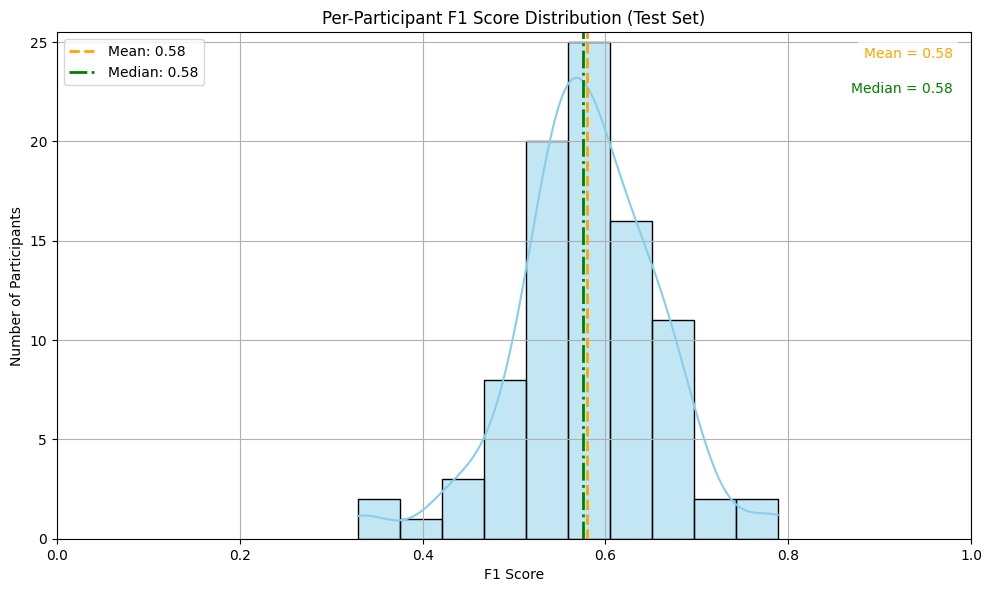

In [63]:
def plot_f1_distribution_for_model(model, test_df, outcome_col='outcome', id_col='participant_id', bins=10, annotate=True, save_path=None):
    """
    Compute per-participant F1 scores for `model` on `test_df`, plot the distribution (hist + KDE),
    highlight mean and median with vertical lines, optionally annotate numeric values and save the figure.

    Args:
        model: fitted classifier with .predict (and optionally .predict_proba)
        test_df: DataFrame containing test rows (must include participant id and outcome)
        outcome_col: name of the label column (default 'outcome')
        id_col: name of the participant id column (default 'participant_id')
        bins: histogram bins (int or sequence)
        annotate: whether to write mean/median text on the plot
        save_path: optional filepath to save the figure (png)

    Returns:
        f1_df: DataFrame with columns ['participant_id', 'f1_score']
    """
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    participant_ids = test_df[id_col].unique()
    rows = []
    for pid in participant_ids:
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        y_true = user_df[outcome_col]
        if len(y_true.unique()) < 2:
            f1 = np.nan
        else:
            feature_cols = [c for c in user_df.columns if c not in [outcome_col, id_col]]
            X_user = user_df[feature_cols]
            y_pred = model.predict(X_user)
            f1 = f1_score(y_true, y_pred, zero_division=0)
        rows.append({'participant_id': pid, 'f1_score': f1})

    f1_df = pd.DataFrame(rows)
    mean_f1 = f1_df['f1_score'].mean()
    median_f1 = f1_df['f1_score'].median()

    plt.figure(figsize=(10, 6))
    ax = sns.histplot(f1_df['f1_score'].dropna(), bins=bins, kde=True, color='skyblue')
    ax = plt.gca()
    # enforce x-limits and tighten vertical margins so plot area is used efficiently
    ax.set_xlim(0, 1)
    ax.margins(y=0.02)

    # vertical lines for mean and median
    ax.axvline(mean_f1, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_f1:.2f}')
    ax.axvline(median_f1, color='green', linestyle='-.', linewidth=2, label=f'Median: {median_f1:.2f}')

    plt.xlabel('F1 Score')
    plt.ylabel('Number of Participants')
    plt.title('Per-Participant F1 Score Distribution (Test Set)')
    plt.xlim(0, 1)
    plt.legend()
    plt.grid(True)

    if annotate:
        # Use axes coordinates so the text stays within the plotting area
        txt_x = 0.98
        ax.text(txt_x, 0.95, f'Mean = {mean_f1:.2f}', horizontalalignment='right', color='orange', fontsize=10, transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
        ax.text(txt_x, 0.88, f'Median = {median_f1:.2f}', horizontalalignment='right', color='green', fontsize=10, transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))

    plt.tight_layout(pad=1.0)

    if save_path is not None:
        try:
            plt.savefig(save_path, dpi=200)
            print(f'Figure saved to {save_path}')
        except Exception as e:
            print('Warning: failed to save figure:', e)

    plt.show()
    return f1_df

# Example usage:
f1_df = plot_f1_distribution_for_model(best_xgb, test_df, annotate=True, save_path='f1_dist_xgb.png')

In [64]:
def export_f1_scores_for_model(model, test_df, filename='f1_scores_by_participant.csv', outcome_col='outcome', id_col='participant_id', output_dir=None, overwrite=True):
    """
    Compute per-participant F1 scores for `model` on `test_df` and export to CSV.

    Args:
        model: fitted classifier with .predict
        test_df: DataFrame containing test rows (must include participant id and outcome)
        filename: name of CSV file to write (default 'f1_scores_by_participant.csv')
        outcome_col: label column name (default 'outcome')
        id_col: participant id column name (default 'participant_id')
        output_dir: directory to save file. If None, defaults to
                    '/Users/adityaponnada/Downloads/time_study_data/trained_models'
        overwrite: if True, overwrite existing file; otherwise, will not overwrite and will warn

    Returns:
        f1_df: DataFrame with columns ['participant_id', 'f1_score']
    """
    import os
    import pandas as pd
    import numpy as np
    from sklearn.metrics import f1_score

    if output_dir is None:
        output_dir = '/Users/adityaponnada/Downloads/time_study_data/trained_models'
    os.makedirs(output_dir, exist_ok=True)

    participant_ids = test_df[id_col].unique()
    rows = []
    for pid in participant_ids:
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        y_true = user_df[outcome_col]
        if len(y_true.unique()) < 2:
            f1 = np.nan
        else:
            feature_cols = [c for c in user_df.columns if c not in [outcome_col, id_col]]
            X_user = user_df[feature_cols]
            y_pred = model.predict(X_user)
            f1 = f1_score(y_true, y_pred, zero_division=0)
        rows.append({'participant_id': pid, 'f1_score': f1})

    f1_df = pd.DataFrame(rows)

    out_path = os.path.join(output_dir, filename)
    try:
        f1_df.to_csv(out_path, index=False)
        print(f"F1 scores exported to {out_path}")
    except Exception as e:
        print("Failed to save F1 scores:", e)

    return f1_df

# Example usage:
f1_df = export_f1_scores_for_model(best_xgb, test_df, filename='f1_best_xgb.csv', overwrite=True)
# print(f1_df.head())

F1 scores exported to /Users/adityaponnada/Downloads/time_study_data/trained_models/f1_best_xgb.csv


In [65]:
def save_model_as_pickle(model, filename='best_model.pkl', output_dir=None, overwrite=True):
    """
    Save a fitted sklearn/xgboost model to disk as a pickle file.

    Defaults to the same folder used for other exports:
    '/Users/adityaponnada/Downloads/time_study_data/trained_models'

    Args:
        model: fitted model object
        filename: output filename (e.g. 'best_xgb.pkl')
        output_dir: directory to save the file; if None, uses the default trained_models folder
        overwrite: if True, overwrite existing file

    Returns:
        out_path: path to the saved pickle file
    """
    import os
    import pickle

    if output_dir is None:
        output_dir = '/Users/adityaponnada/Downloads/time_study_data/trained_models'
    os.makedirs(output_dir, exist_ok=True)

    out_path = os.path.join(output_dir, filename)
    if os.path.exists(out_path) and not overwrite:
        print(f"File exists and overwrite=False: {out_path}")
        return out_path

    try:
        with open(out_path, 'wb') as f:
            pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Model saved to {out_path}")
    except Exception as e:
        print('Failed to save model:', e)
        raise

    return out_path

# Example usage:
save_model_as_pickle(best_xgb, 'best_xgb_generalized.pkl', overwrite=True)
# If you'd like the model saved automatically after random search, call the above with the returned estimator.


Model saved to /Users/adityaponnada/Downloads/time_study_data/trained_models/best_xgb_generalized.pkl


'/Users/adityaponnada/Downloads/time_study_data/trained_models/best_xgb_generalized.pkl'